In [1]:
import pickle
import numpy as np
from scipy.signal import welch as psd_welch
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
# Takes a minute or so
with open("./data/preprocessed/all_data.pkl", "rb") as fp:
    data = pickle.load(fp)

In [3]:
# avoid redoing our psd calculations
df = pd.read_csv("./data/preprocessed/data.csv")
X = df.to_numpy()
X = X[:,1:]
Xpsd = X[:,1:7]
Xpsd_rel = X[:,7:13]

In [4]:
FREQ_BANDS = {
    "delta": [0.5, 4.0],
    "theta": [4.0, 8.0],
    "alpha": [8.0, 12.0],
    "sigma": [12.0, 16.0],
    "beta": [16.0, 30.0],
    "gamma": [30.0, 40.0]
}

Fs = 100
Ts = 1/Fs

In [5]:
def data_to_binned_psd(x, freq_bins=FREQ_BANDS.values()):
    freqs, x_psd = psd_welch(x, fs=Fs, return_onesided=True)
    bins = np.zeros(len(freq_bins))
    for i, (freq_start, freq_end) in enumerate(freq_bins):
        mask = (freqs >= freq_start) & (freqs <= freq_end)
        x_psd_bin = x_psd[mask]
        bins[i] = np.mean(x_psd_bin)
    return bins

In [6]:
# get frequency bins
Xpsd = []
Xpsd_rel = []
for _, _, x in tqdm(data):
    x_psd = data_to_binned_psd(x)
    x_psd_rel = x_psd / np.sum(x_psd)
    Xpsd.append(x_psd)
    Xpsd_rel.append(x_psd_rel)

100%|███████████████████████████████████████████████████████████████████████████| 45222/45222 [00:46<00:00, 969.81it/s]


In [7]:
# get hjorth measurements
Xactivity = []
Xmobility = []
Xcomplexity = []

def mobility(y):
    dy_dt = np.gradient(y)
    return (np.var(dy_dt)/np.var(y))**0.5

for _, _, x in tqdm(data):
    dx_dt = np.gradient(x)
    x_activity = np.var(x)
    x_mobility = mobility(x)
    x_complexity = mobility(dx_dt)/x_mobility
    
    Xactivity.append(x_activity)
    Xmobility.append(x_mobility)
    Xcomplexity.append(x_complexity)

100%|██████████████████████████████████████████████████████████████████████████| 45222/45222 [00:24<00:00, 1867.44it/s]


In [8]:
# get entropy
Xentropy = []
for _, _, x in tqdm(data):
    x = x-np.min(x) + 0.01
    px = x/np.sum(x)
    x_entropy = -np.sum(px*np.log2(px))
    Xentropy.append(x_entropy)

100%|██████████████████████████████████████████████████████████████████████████| 45222/45222 [00:09<00:00, 4760.55it/s]


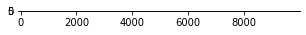

In [21]:
fig = plt.figure(figsize=(5,10))
plt.imshow(np.array(Xpsd[:10000]).T)

In [9]:
Nsamples = len(data)
data_export = []
for i in tqdm(range(Nsamples)):
    pid, y, _ = data[i]
    x_psd = Xpsd[i]
    x_psd_rel = Xpsd_rel[i]
    x_activity = Xactivity[i]
    x_mobility = Xmobility[i]
    x_complexity = Xcomplexity[i]
    x_entropy = Xentropy[i]
    entry = [
        pid, 
        *x_psd, *x_psd_rel, 
        x_activity, x_mobility, x_complexity,
        x_entropy,
        y]
    data_export.append(entry)

100%|████████████████████████████████████████████████████████████████████████| 45222/45222 [00:00<00:00, 145431.16it/s]


In [10]:
columns = [
    "patient_id", 
    *[f"Xpsd_{i}" for i in range(6)], 
    *[f"Xpsd_rel_{i}" for i in range(6)], 
    "activity",
    "mobility",
    "complexity",
    "entropy",
    "Y"]
df = pd.DataFrame(data_export, columns=columns)
df.to_csv("./data/preprocessed/data.csv", index=False)